## 14. 비정형 데이터 실습

### 14.1. 이미지 분류

In [1]:
using MLDatasets: MNIST
# 필요 데이터 자동 다운로드
ENV["DATADEPS_ALWAYS_ACCEPT"] = true
trainset = MNIST(:train)
testset = MNIST(:test)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

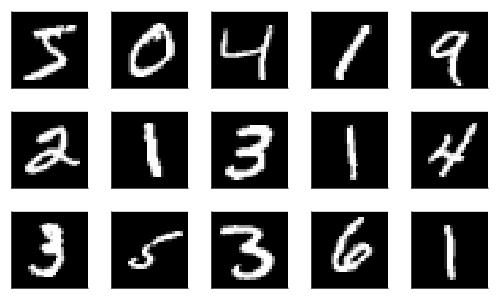

In [2]:
using MLDatasets: convert2image
using Plots, ImageShow
gr(size=(500,300))
imgs = [heatmap(convert2image(trainset, i), ticks=[]) for i in 1:15]
plot(imgs..., layout=(3,5))

데이터 정형화

In [3]:
using DataFrames, MLJ
img_size = prod(size(trainset.features)[1:2]); # 28 * 28
train_flat = reshape(trainset.features, img_size, :);
X_train = DataFrame(transpose(train_flat), :auto);
y_train = coerce(trainset.targets, Multiclass);
test_flat = reshape(testset.features, img_size, :);
X_test = DataFrame(transpose(test_flat), :auto);
y_test = coerce(testset.targets, Multiclass);

다양한 모델 적용

In [4]:
Logistic = @load LogisticClassifier pkg=MLJLinearModels verbosity=0;
solver = MLJLinearModels.ProxGrad(accel=true, tol=0.01);
model = Logistic(penalty=:l1, lambda=0.0, solver=solver);
mach = machine(model, X_train, y_train);
@time fit!(mach, verbosity=0);
accuracy(predict_mode(mach, X_test), y_test)

 73.850889 seconds (29.33 M allocations: 47.777 GiB, 3.35% gc time, 9.40% compilation time)


0.9203

In [5]:
PCA = @load PCA pkg=MultivariateStats verbosity=0;
model = PCA(variance_ratio=0.98) |> 
    Logistic(penalty=:l1, lambda=0.0, solver=solver);
mach = machine(model, X_train, y_train);
@time fit!(mach, verbosity=0);
accuracy(predict_mode(mach, X_test), y_test) 

 35.783531 seconds (31.81 M allocations: 19.336 GiB, 3.49% gc time, 26.49% compilation time)


0.9247

In [6]:
report(mach).pca

(indim = 784,
 outdim = 261,
 tprincipalvar = 51.678707f0,
 tresidualvar = 1.0472069f0,
 tvar = 52.725914f0,
 mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.00078601314, 0.00034849675, 0.00017895426, 7.562091f-5, 5.9281047f-5, 7.843138f-6, 0.0, 0.0, 0.0, 0.0],
 principalvars = Float32[5.116875, 3.741391, 3.2527087, 2.8416212, 2.5671184, 2.2736633, 1.725155, 1.5205601, 1.456305, 1.24275  …  0.00996926, 0.009913143, 0.009827689, 0.009798978, 0.009734149, 0.009685487, 0.009656566, 0.009589811, 0.009483591, 0.00936184],
 loadings = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],)

In [7]:
model = PCA(maxoutdim=40) |> 
    InteractionTransformer(order=2) |> 
    Logistic(penalty=:l1, lambda=0.0, solver=solver);
mach = machine(model, X_train, y_train);
@time fit!(mach, verbosity=0);
accuracy(predict_mode(mach, X_test), y_test)

 86.942768 seconds (19.58 M allocations: 52.392 GiB, 2.64% gc time, 14.54% compilation time)


0.9784

In [8]:
KNN = @load KNNClassifier pkg=NearestNeighborModels verbosity=0;
SVM = @load SVC pkg=LIBSVM verbosity=0;
XGB = @load XGBoostClassifier pkg=XGBoost verbosity=0;
LGBM = @load LGBMClassifier pkg=LightGBM verbosity=0;

logistic = Logistic(penalty=:l1, lambda=0.0, solver=solver);
knn = KNN(); # K = 5
svm = SVM(); # kernel = RadialBasis
xgb = XGB(); # num_round = 100
lgbm = LGBM(num_iterations=100);

┌ Info: lib_lightgbm not found in system dirs, trying fallback
└ @ LightGBM /home/tyfun/.julia/packages/LightGBM/3367V/src/LightGBM.jl:26


In [9]:
function get_model(ty, clf)
    ty == 1 ? clf :
    ty == 2 ? (PCA(variance_ratio=0.98) |> clf) :
    (PCA(maxoutdim=40) |> InteractionTransformer(order=2) |> clf)
end

function run_batch(ty, clfs, X_tr, y_tr, X_te, y_te)
    res = []
    for clf in clfs
        model = get_model(ty, clf)
        mach = machine(model, X_tr, y_tr)
        fit_t = @elapsed fit!(mach, verbosity=0)
        is_proba = prediction_type(clf) == :probabilistic
        oper = is_proba ? predict_mode : predict
        pred_t = @elapsed pred = oper(mach, X_te)
        acc = accuracy(pred, y_te)
        stats = (fit_t, pred_t, acc)
        r = clf => round.(stats, digits=4)
        println(r)
        push!(res, r)
    end
    res
end

run_batch (generic function with 1 method)

In [10]:
clfs = [logistic, knn, svm, xgb, lgbm];
res1 = run_batch(1, clfs, X_train, y_train, X_test, y_test);
res2 = run_batch(2, clfs, X_train, y_train, X_test, y_test);
res3 = run_batch(3, clfs, X_train, y_train, X_test, y_test);
res = vcat(res1, res2, res3)

LogisticClassifier(lambda = 0.0, …) => (66.4557, 0.4004, 0.9203)


KNNClassifier(K = 5, …) => (15.7088, 165.6103, 0.9688)


SVC(kernel = RadialBasis, …) => (460.431, 134.787, 0.9793)


XGBoostClassifier(test = 1, …) => (1106.3586, 1.8925, 0.9795)


LGBMClassifier(boosting = gbdt, …) => (109.5162, 1.0208, 0.9774)


LogisticClassifier(lambda = 0.0, …) => (26.8899, 0.4256, 0.9247)


KNNClassifier(K = 5, …) => (4.0288, 42.5239, 0.9694)


SVC(kernel = RadialBasis, …) => (215.3889, 48.0033, 0.9829)


XGBoostClassifier(test = 1, …) => (2181.8582, 0.6743, 0.9624)


LGBMClassifier(boosting = gbdt, …) => (101.0736, 1.2348, 0.9623)


LogisticClassifier(lambda = 0.0, …) => (82.0828, 0.4328, 0.9784)


KNNClassifier(K = 5, …) => (18.5371, 167.6255, 0.9735)


SVC(kernel = RadialBasis, …) => (819.6216, 169.7701, 0.9844)


XGBoostClassifier(test = 1, …) => (6564.1792, 0.7099, 0.9697)


LGBMClassifier(boosting = gbdt, …) => (316.9032, 1.2017, 0.9691)


15-element Vector{Any}:
 LogisticClassifier(lambda = 0.0, …) => (66.4557, 0.4004, 0.9203)
             KNNClassifier(K = 5, …) => (15.7088, 165.6103, 0.9688)
        SVC(kernel = RadialBasis, …) => (460.431, 134.787, 0.9793)
      XGBoostClassifier(test = 1, …) => (1106.3586, 1.8925, 0.9795)
  LGBMClassifier(boosting = gbdt, …) => (109.5162, 1.0208, 0.9774)
 LogisticClassifier(lambda = 0.0, …) => (26.8899, 0.4256, 0.9247)
             KNNClassifier(K = 5, …) => (4.0288, 42.5239, 0.9694)
        SVC(kernel = RadialBasis, …) => (215.3889, 48.0033, 0.9829)
      XGBoostClassifier(test = 1, …) => (2181.8582, 0.6743, 0.9624)
  LGBMClassifier(boosting = gbdt, …) => (101.0736, 1.2348, 0.9623)
 LogisticClassifier(lambda = 0.0, …) => (82.0828, 0.4328, 0.9784)
             KNNClassifier(K = 5, …) => (18.5371, 167.6255, 0.9735)
        SVC(kernel = RadialBasis, …) => (819.6216, 169.7701, 0.9844)
      XGBoostClassifier(test = 1, …) => (6564.1792, 0.7099, 0.9697)
  LGBMClassifier(boosting = gbdt, 

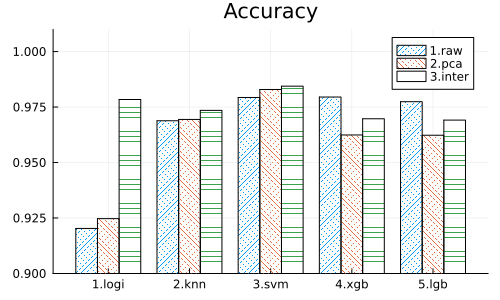

In [37]:
using StatsPlots
gr(size=(500,300))
clfnms = ["1.logi", "2.knn", "3.svm", "4.xgb", "5.lgb"];
group = repeat(["1.raw", "2.pca", "3.inter"], inner=5);
x = repeat(clfnms, outer=3);
y = transpose(reduce(hcat, collect.(last.(res))))
groupedbar(x, y[:,3], group=group, ylim=[0.9,1.01], title="Accuracy", fillstyle=[:/ :\ :-])

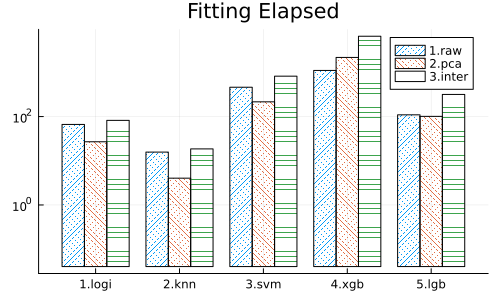

In [40]:
groupedbar(x, y[:,1], group=group, yaxis=:log, title="Fitting Elapsed", fillstyle=[:/ :\ :-])

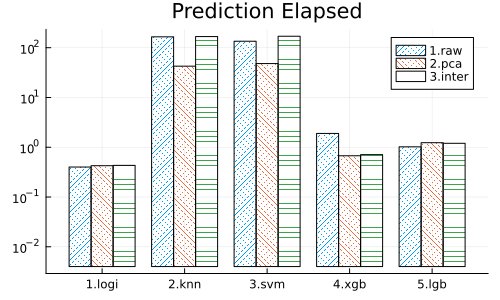

In [41]:
groupedbar(x, y[:,2], group=group, yaxis=:log, title="Prediction Elapsed", fillstyle=[:/ :\ :-])